# Apache Spark’s Structured APIs

## In this chapter, we will explore the principal motivations behind adding structure to
Apache Spark, how those motivations led to the creation of high-level APIs (Data‐
Frames and Datasets), and their unification in Spark 2.x across its components. We’ll
also look at the Spark SQL engine that underpins these structured high-level APIs.
When Spark SQL was first introduced in the early Spark 1.x releases, followed by
DataFrames as a successor to SchemaRDDs in Spark 1.3, we got our first glimpse of
structure in Spark. Spark SQL introduced high-level expressive operational functions,
mimicking SQL-like syntax, and DataFrames, which laid the foundation for more
structure in subsequent releases, paved the path to performant operations in Spark’s
computational queries.
But before we talk about the newer Structured APIs, let’s get a brief glimpse of what
it’s like to not have structure in Spark by taking a peek at the simple RDD program‐
ming API model.
## Spark: What’s Underneath an RDD?
The RDD is the most basic abstraction in Spark. There are three vital characteristics
associated with an RDD:
* Dependencies
* Partitions (with some locality information)
* Compute function: Partition => Iterator[T]

All three are integral to the simple RDD programming API model upon which all
higher-level functionality is constructed. First, a list of dependencies that instructs
Spark how an RDD is constructed with its inputs is required. When necessary to
reproduce results, Spark can recreate an RDD from these dependencies and replicate
operations on it. This characteristic gives RDDs resiliency.
Second, partitions provide Spark the ability to split the work to parallelize computa‐
tion on partitions across executors. In some cases—for example, reading from
HDFS—Spark will use locality information to send work to executors close to the
data. That way less data is transmitted over the network.
And finally, an RDD has a compute function that produces an Iterator[T] for the
data that will be stored in the RDD.
Simple and elegant! Yet there are a couple of problems with this original model. For
one, the compute function (or computation) is opaque to Spark. That is, Spark does
not know what you are doing in the compute function. Whether you are performing
a join, filter, select, or aggregation, Spark only sees it as a lambda expression. Another
problem is that the Iterator[T] data type is also opaque for Python RDDs; Spark
only knows that it’s a generic object in Python.
Furthermore, because it’s unable to inspect the computation or expression in the
function, Spark has no way to optimize the expression—it has no comprehension of
its intention. And finally, Spark has no knowledge of the specific data type in T. To
Spark it’s an opaque object; it has no idea if you are accessing a column of a certain
type within an object. Therefore, all Spark can do is serialize the opaque object as a
series of bytes, without using any data compression techniques.
This opacity clearly hampers Spark’s ability to rearrange your computation into an
efficient query plan. So what’s the solution?

## Structuring Spark
Spark 2.x introduced a few key schemes for structuring Spark. One is to express com‐
putations by using common patterns found in data analysis. These patterns are
expressed as high-level operations such as filtering, selecting, counting, aggregating,
averaging, and grouping. This provides added clarity and simplicity.
This specificity is further narrowed through the use of a set of common operators in a
DSL. Through a set of operations in DSL, available as APIs in Spark’s supported lan‐
guages (Java, Python, Spark, R, and SQL), these operators let you tell Spark what you
wish to compute with your data, and as a result, it can construct an efficient query
plan for execution.

And the final scheme of order and structure is to allow you to arrange your data in a
tabular format, like a SQL table or spreadsheet, with supported structured data types
(which we will cover shortly).
But what’s all this structure good for?
#### Key Merits and Benefits
Structure yields a number of benefits, including better performance and space effi‐
ciency across Spark components. We will explore these benefits further when we talk
about the use of the DataFrame and Dataset APIs shortly, but for now we’ll concen‐
trate on the other advantages: expressivity, simplicity, composability, and uniformity.
Let’s demonstrate expressivity and composability first, with a simple code snippet. In
the following example, we want to aggregate all the ages for each name, group by
name, and then average the ages—a common pattern in data analysis and discovery.
If we were to use the low-level RDD API for this, the code would look as follows:
~~~
# In Python
# Create an RDD of tuples (name, age)
dataRDD = sc.parallelize([("Brooke", 20), ("Denny", 31), ("Jules", 30),
 ("TD", 35), ("Brooke", 25)])
# Use map and reduceByKey transformations with their lambda
# expressions to aggregate and then compute average
agesRDD = (dataRDD
 .map(lambda x: (x[0], (x[1], 1)))
 .reduceByKey(lambda x, y: (x[0] + y[0], x[1] + y[1]))
 .map(lambda x: (x[0], x[1][0]/x[1][1])))
 ~~~
No one would dispute that this code, which tells Spark how to aggregate keys and
compute averages with a string of lambda functions, is cryptic and hard to read. In
other words, the code is instructing Spark how to compute the query. It’s completely
opaque to Spark, because it doesn’t communicate the intention. Furthermore, the
equivalent RDD code in Scala would look very different from the Python code shown
here.
By contrast, what if we were to express the same query with high-level DSL operators
and the DataFrame API, thereby instructing Spark what to do? Have a look:
http://localhost:8888/notebooks/chapter3/1.DataFrame_pyspark.ipynb
This version of the code is far more expressive as well as simpler than the earlier ver‐
sion, because we are using high-level DSL operators and APIs to tell Spark what to
do. In effect, we have employed these operators to compose our query. And because
Spark can inspect or parse this query and understand our intention, it can optimize
or arrange the operations for efficient execution. Spark knows exactly what we wish
to do: group people by their names, aggregate their ages, and then compute the aver‐
age age of all people with the same name. We’ve composed an entire computation
using high-level operators as a single simple query—how expressive is that?
Some would contend that by using only high-level, expressive DSL operators mapped
to common or recurring data analysis patterns to introduce order and structure, we
are limiting the scope of the developers’ ability to instruct the compiler or control
how their queries should be computed. Rest assured that you are not confined to
these structured patterns; you can switch back at any time to the unstructured lowlevel RDD API, although we hardly ever find a need to do so.

As well as being simpler to read, the structure of Spark’s high-level APIs also introdu‐
ces uniformity across its components and languages. For example, the Scala code
shown here does the same thing as the previous Python code—and the API looks
nearly identical:
http://localhost:8888/notebooks/chapter3/1.DataFrame_scala.ipynb
Some of these DSL operators perform relational-like operations
that you’ll be familiar with if you know SQL, such as selecting, fil‐
tering, grouping, and aggregation.

All of this simplicity and expressivity that we developers cherish is possible because of
the Spark SQL engine upon which the high-level Structured APIs are built. It is
because of this engine, which underpins all the Spark components, that we get uni‐
form APIs. Whether you express a query against a DataFrame in Structured Stream‐
ing or MLlib, you are always transforming and operating on DataFrames as
structured data. We’ll take a closer look at the Spark SQL engine later in this chapter,
but for now let’s explore those APIs and DSLs for common operations and how to use
them for data analytics.

## The DataFrame API
Inspired by pandas DataFrames in structure, format, and a few specific operations,
Spark DataFrames are like distributed in-memory tables with named columns and
schemas, where each column has a specific data type: integer, string, array, map, real,
date, timestamp, etc. To a human’s eye, a Spark DataFrame is like a table. An example
is shown in Table 3-1.
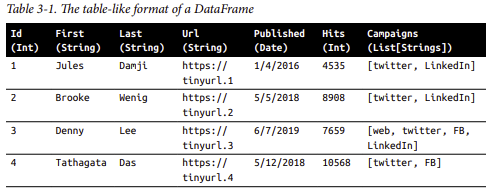
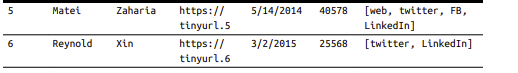
When data is visualized as a structured table, it’s not only easy to digest but also easy
to work with when it comes to common operations you might want to execute on
rows and columns. Also recall that, as you learned in Chapter 2, DataFrames are
immutable and Spark keeps a lineage of all transformations. You can add or change
the names and data types of the columns, creating new DataFrames while the previ‐
ous versions are preserved. A named column in a DataFrame and its associated Spark
data type can be declared in the schema.
Let’s examine the generic and structured data types available in Spark before we use
them to define a schema. Then we’ll illustrate how to create a DataFrame with a
schema, capturing the data in Table 3-1.

## Spark’s Basic Data Types
Matching its supported programming languages, Spark supports basic internal data
types. These data types can be declared in your Spark application or defined in your
schema. For example, in Scala, you can define or declare a particular column name to
be of type String, Byte, Long, or Map, etc. Here, we define variable names tied to a
Spark data type:
~~~
SPARK_HOME/bin/spark-shell
scala> import org.apache.spark.sql.types._
import org.apache.spark.sql.types._
scala> val nameTypes = StringType
nameTypes: org.apache.spark.sql.types.StringType.type = StringType
scala> val firstName = nameTypes
firstName: org.apache.spark.sql.types.StringType.type = StringType
scala> val lastName = nameTypes
lastName: org.apache.spark.sql.types.StringType.type = StringType
~~~
Table 3-2 lists the basic Scala data types supported in Spark. They all are subtypes of
the class DataTypes, except for DecimalType.


## Spark’s Structured and Complex Data Types
For complex data analytics, you won’t deal only with simple or basic data types. Your
data will be complex, often structured or nested, and you’ll need Spark to handle
these complex data types. They come in many forms: maps, arrays, structs, dates,
timestamps, fields, etc. Table 3-4 lists the Scala structured data types that Spark
supports.

While these tables showcase the myriad types supported, it’s far more important to
see how these types come together when you define a schema for your data.

## Schemas and Creating DataFrames
A schema in Spark defines the column names and associated data types for a Data‐
Frame. Most often, schemas come into play when you are reading structured data
from an external data source (more on this in the next chapter). Defining a schema
up front as opposed to taking a schema-on-read approach offers three benefits:
* You relieve Spark from the onus of inferring data types.
* You prevent Spark from creating a separate job just to read a large portion of
your file to ascertain the schema, which for a large data file can be expensive and
time-consuming.
* You can detect errors early if data doesn’t match the schema.

So, we encourage you to always define your schema up front whenever you want to
read a large file from a data source. For a short illustration, let’s define a schema for
the data in Table 3-1 and use that schema to create a DataFrame.
#### Two ways to define a schema
Spark allows you to define a schema in two ways. One is to define it programmati‐
cally, and the other is to employ a Data Definition Language (DDL) string, which is
much simpler and easier to read.

To define a schema programmatically for a DataFrame with three named columns,
author, title, and pages, you can use the Spark DataFrame API. For example:
~~~
// In Scala
import org.apache.spark.sql.types._
val schema = StructType(Array(StructField("author", StringType, false),
 StructField("title", StringType, false),
 StructField("pages", IntegerType, false)))
# In Python
from pyspark.sql.types import *
schema = StructType([StructField("author", StringType(), False),
 StructField("title", StringType(), False),
 StructField("pages", IntegerType(), False)])
Defining the same schema using DDL is much simpler:
// In Scala
val schema = "author STRING, title STRING, pages INT"
# In Python
schema = "author STRING, title STRING, pages INT"
~~~
You can choose whichever way you like to define a schema. For many examples, we
will use both:

In [9]:
# In Python
from pyspark.sql import SparkSession

# Define schema for our data using DDL
schema = """Id INT, First STRING, Last STRING, Url STRING, Published STRING, Hits INT, 
Campaigns ARRAY<STRING>"""

# Create our static data
data = [
    [1, "Jules", "Damji", "https://tinyurl.1", "1/4/2016", 4535, ["twitter","LinkedIn"]],
    [2, "Brooke","Wenig", "https://tinyurl.2", "5/5/2018", 8908, ["twitter","LinkedIn"]],
    [3, "Denny", "Lee", "https://tinyurl.3", "6/7/2019", 7659, ["web","twitter", "FB", 
                                                                "LinkedIn"]],
    [4, "Tathagata", "Das", "https://tinyurl.4", "5/12/2018", 10568,["twitter", "FB"]],
    [5, "Matei","Zaharia", "https://tinyurl.5", "5/14/2014", 40578, ["web","twitter", 
                                                                     "FB", "LinkedIn"]],
    [6, "Reynold", "Xin", "https://tinyurl.6", "3/2/2015", 25568,["twitter", "LinkedIn"]]
]

In [10]:
# Create a SparkSession
spark = (SparkSession
 .builder
 .appName("Example-3_6")
 .getOrCreate())
# Create a DataFrame using the schema defined above
blogs_df = spark.createDataFrame(data, schema)
# Show the DataFrame; it should reflect our table above
blogs_df.show()
# Print the schema used by Spark to process the DataFrame
print(blogs_df.printSchema())

+---+---------+-------+-----------------+---------+-----+--------------------+
| Id|    First|   Last|              Url|Published| Hits|           Campaigns|
+---+---------+-------+-----------------+---------+-----+--------------------+
|  1|    Jules|  Damji|https://tinyurl.1| 1/4/2016| 4535| [twitter, LinkedIn]|
|  2|   Brooke|  Wenig|https://tinyurl.2| 5/5/2018| 8908| [twitter, LinkedIn]|
|  3|    Denny|    Lee|https://tinyurl.3| 6/7/2019| 7659|[web, twitter, FB...|
|  4|Tathagata|    Das|https://tinyurl.4|5/12/2018|10568|       [twitter, FB]|
|  5|    Matei|Zaharia|https://tinyurl.5|5/14/2014|40578|[web, twitter, FB...|
|  6|  Reynold|    Xin|https://tinyurl.6| 3/2/2015|25568| [twitter, LinkedIn]|
+---+---------+-------+-----------------+---------+-----+--------------------+

root
 |-- Id: integer (nullable = true)
 |-- First: string (nullable = true)
 |-- Last: string (nullable = true)
 |-- Url: string (nullable = true)
 |-- Published: string (nullable = true)
 |-- Hits: integer (

If you want to use this schema elsewhere in your code, simply execute
blogs_df.schema and it will return the schema definition:
~~~
StructType(List(StructField("Id",IntegerType,false),
StructField("First",StringType,false),
StructField("Last",StringType,false),
StructField("Url",StringType,false),
StructField("Published",StringType,false),
StructField("Hits",IntegerType,false),
StructField("Campaigns",ArrayType(StringType,true),false)))
~~~
As you can observe, the DataFrame layout matches that of Table 3-1 along with the
respective data types and schema output.
If you were to read the data from a JSON file instead of creating static data, the
schema definition would be identical. Let’s illustrate the same code with a Scala exam‐
ple, this time reading from a JSON file:
~~~
// In Scala
package main.scala.chapter3
import org.apache.spark.sql.SparkSession
import org.apache.spark.sql.types._
object Example3_7 {
def main(args: Array[String]) {
 val spark = SparkSession
 .builder
 .appName("Example-3_7")
 .getOrCreate()
 if (args.length <= 0) {
 println("usage Example3_7 <file path to blogs.json>")
 System.exit(1)
 }
 // Get the path to the JSON file
 val jsonFile = args(0)
 // Define our schema programmatically
 val schema = StructType(Array(StructField("Id", IntegerType, false),
 StructField("First", StringType, false),
 StructField("Last", StringType, false),
 StructField("Url", StringType, false),
 StructField("Published", StringType, false),
 StructField("Hits", IntegerType, false),
 StructField("Campaigns", ArrayType(StringType), false)))
 // Create a DataFrame by reading from the JSON file
 // with a predefined schema
 val blogsDF = spark.read.schema(schema).json(jsonFile)
 // Show the DataFrame schema as output
 blogsDF.show(false)
 // Print the schema
 println(blogsDF.printSchema)
 println(blogsDF.schema)
}
}
~~~
Not surprisingly, the output from the Scala program is no different than that from the
Python program

Now that you have an idea of how to use structured data and schemas in DataFrames,
let’s focus on DataFrame columns and rows and what it means to operate on them
with the DataFrame API.

## Columns and Expressions
As mentioned previously, named columns in DataFrames are conceptually similar to
named columns in pandas or R DataFrames or in an RDBMS table: they describe a
type of field. You can list all the columns by their names, and you can perform opera‐
tions on their values using relational or computational expressions. In Spark’s sup‐
ported languages, columns are objects with public methods (represented by the
Column type).

You can also use logical or mathematical expressions on columns. For example, you
could create a simple expression using expr("columnName * 5") or (expr("colum
nName - 5") > col(anothercolumnName)), where columnName is a Spark type (inte‐
ger, string, etc.). expr() is part of the pyspark.sql.functions (Python) and
org.apache.spark.sql.functions (Scala) packages. Like any other function in those
packages, expr() takes arguments that Spark will parse as an expression, computing
the result.

Scala, Java, and Python all have public methods associated with col‐
umns. You’ll note that the Spark documentation refers to both col
and Column. Column is the name of the object, while col() is a stan‐
dard built-in function that returns a Column.

Let’s take a look at some examples of what we can do with columns in Spark. Each
example is followed by its output:

Scala
http://localhost:8888/notebooks/chapter3/2.Example_3_7_Scala.ipynb

Python
http://localhost:8888/notebooks/chapter3/2.Example-3_6_pyspark.ipynb

## Rows
A row in Spark is a generic Row object, containing one or more columns. Each col‐
umn may be of the same data type (e.g., integer or string), or they can have different
types (integer, string, map, array, etc.). Because Row is an object in Spark and an
ordered collection of fields, you can instantiate a Row in each of Spark’s supported lan‐
guages and access its fields by an index starting at 0:

Scala
http://localhost:8888/notebooks/chapter3/3.rows_scala.ipynb

Python
http://localhost:8888/notebooks/chapter3/3.rows_pyspark.ipynb

In practice, though, you will usually want to read DataFrames from a file as illustrated
earlier. In most cases, because your files are going to be huge, defining a schema and
using it is a quicker and more efficient way to create DataFrames.
After you have created a large distributed DataFrame, you are going to want to per‐
form some common data operations on it. Let’s examine some of the Spark opera‐
tions you can perform with high-level relational operators in the Structured APIs.

## Common DataFrame Operations
To perform common data operations on DataFrames, you’ll first need to load a Data‐
Frame from a data source that holds your structured data. Spark provides an inter‐
face, DataFrameReader, that enables you to read data into a DataFrame from myriad
data sources in formats such as JSON, CSV, Parquet, Text, Avro, ORC, etc. Likewise,
to write a DataFrame back to a data source in a particular format, Spark uses
DataFrameWriter.
### Using DataFrameReader and DataFrameWriter
Reading and writing are simple in Spark because of these high-level abstractions and
contributions from the community to connect to a wide variety of data sources,
including common NoSQL stores, RDBMSs, streaming engines such as Apache Kafka
and Kinesis, and more.
To get started, let’s read a large CSV file containing data on San Francisco Fire
Department calls.1
 As noted previously, we will define a schema for this file and use
the DataFrameReader class and its methods to tell Spark what to do. Because this file
contains 28 columns and over 4,380,660 records,2
 it’s more efficient to define a schema than have Spark infer it.
 If you don’t want to specify the schema, Spark can infer schema
from a sample at a lesser cost. For example, you can use the samplingRatio option:

 Scala http://localhost:8888/notebooks/chapter3/4.scala_Using%20DataFrameReader%20and%20DataFrameWriter.ipynb
 
Python
http://localhost:8888/notebooks/chapter3/4.pyspark_Using%20DataFrameReader%20and%20DataFrameWriter.ipynb

The spark.read.csv() function reads in the CSV file and returns a DataFrame of
rows and named columns with the types dictated in the schema.
To write the DataFrame into an external data source in your format of choice, you
can use the DataFrameWriter interface. Like DataFrameReader, it supports multiple
data sources. Parquet, a popular columnar format, is the default format; it uses
snappy compression to compress the data. If the DataFrame is written as Parquet, the
schema is preserved as part of the Parquet metadata. In this case, subsequent reads
back into a DataFrame do not require you to manually supply a schema.

___Saving a DataFrame as a Parquet file or SQL table.___ A common data operation is to explore
and transform your data, and then persist the DataFrame in Parquet format or save it
as a SQL table. Persisting a transformed DataFrame is as easy as reading it. For exam‐
ple, to persist the DataFrame we were just working with as a file after reading it you
would do the following:
~~~
// In Scala to save as a Parquet file
val parquetPath = ...
fireDF.write.format("parquet").save(parquetPath)
# In Python to save as a Parquet file
parquet_path = ...
fire_df.write.format("parquet").save(parquet_path)
~~~
Alternatively, you can save it as a table, which registers metadata with the Hive meta‐
store (we will cover SQL managed and unmanaged tables, metastores, and Data‐
Frames in the next chapter):
~~~
// In Scala to save as a table
val parquetTable = ... // name of the table
fireDF.write.format("parquet").saveAsTable(parquetTable)
# In Python
parquet_table = ... # name of the table
fire_df.write.format("parquet").saveAsTable(parquet_table)
~~~
Let’s walk through some common operations to perform on DataFrames after you
have read the data.
#### Transformations and actions
Now that you have a distributed DataFrame composed of San Francisco Fire Depart‐
ment calls in memory, the first thing you as a developer will want to do is examine
your data to see what the columns look like. Are they of the correct types? Do any of
them need to be converted to different types? Do they have null values?
In “Transformations, Actions, and Lazy Evaluation” on page 28 in Chapter 2, you got
a glimpse of how transformations and actions are used to operate on DataFrames,
and saw some common examples of each. What can we find out from our San Fran‐
cisco Fire Department calls using these?
___Projections and filters.___ A projection in relational parlance is a way to return only the
rows matching a certain relational condition by using filters. In Spark, projections are
done with the select() method, while filters can be expressed using the filter() or
where() method. We can use this technique to examine specific aspects of our SF Fire
Department data set:
http://localhost:8888/notebooks/chapter3/3-2%20San%20Francisco%20Fire%20Calls_PySpark.ipynb

http://localhost:8888/notebooks/chapter3/3-2%20San%20Francisco%20Fire%20Calls_Scala.ipynb

___Renaming, adding, and dropping columns.___ Sometimes you want to rename particular
columns for reasons of style or convention, and at other times for readability or brev‐
ity. The original column names in the SF Fire Department data set had spaces in
them. For example, the column name IncidentNumber was Incident Number. Spaces
in column names can be problematic, especially when you want to write or save a
DataFrame as a Parquet file (which prohibits this).
By specifying the desired column names in the schema with StructField, as we did,
we effectively changed all names in the resulting DataFrame.
Alternatively, you could selectively rename columns with the withColumnRenamed()
method. For instance, let’s change the name of our Delay column to ResponseDe
layedinMins and take a look at the response times that were longer than five
minutes:

http://localhost:8888/notebooks/chapter3/3-2%20San%20Francisco%20Fire%20Calls_PySpark.ipynb

http://localhost:8888/notebooks/chapter3/3-2%20San%20Francisco%20Fire%20Calls_Scala.ipynb

Because DataFrame transformations are immutable, when we
rename a column using withColumnRenamed() we get a new DataFrame while retaining the original with the old column name.

Modifying the contents of a column or its type are common operations during data
exploration. In some cases the data is raw or dirty, or its types are not amenable to being supplied as arguments to relational operators. For example, in our SF Fire
Department data set, the columns CallDate, WatchDate, and AlarmDtTm are strings
rather than either Unix timestamps or SQL dates, both of which Spark supports and
can easily manipulate during transformations or actions (e.g., during a date- or timebased analysis of the data).
So how do we convert them into a more usable format? It’s quite simple, thanks to
some high-level API methods. spark.sql.functions has a set of to/from date/timestamp functions such as to_timestamp() and to_date() that we can use for just this
purpose.

Those queries pack quite a punch—a number of things are happening. Let’s unpack
what they do:
1. Convert the existing column’s data type from string to a Spark-supported
timestamp.
2. Use the new format specified in the format string "MM/dd/yyyy" or "MM/dd/yyyy
hh:mm:ss a" where appropriate.
3. After converting to the new data type, drop() the old column and append the
new one specified in the first argument to the withColumn() method.
4. Assign the new modified DataFrame to fire_ts_df.

So far in this section, we have explored a number of common data operations: reading and writing DataFrames; defining a schema and using it when reading in a DataFrame; saving a DataFrame as a Parquet file or table; projecting and filtering selected
columns from an existing DataFrame; and modifying, renaming, and dropping
columns.

One final common operation is grouping data by values in a column and aggregating
the data in some way, like simply counting it. This pattern of grouping and counting
is as common as projecting and filtering. Let’s have a go at it.

___Aggregations.___ What if we want to know what the most common types of fire calls
were, or what zip codes accounted for the most calls? These kinds of questions are
common in data analysis and exploration.

A handful of transformations and actions on DataFrames, such as groupBy(),
orderBy(), and count(), offer the ability to aggregate by column names and then
aggregate counts across them.

For larger DataFrames on which you plan to conduct frequent or
repeated queries, you could benefit from caching. We will cover
DataFrame caching strategies and their benefits in later chapters.

Let’s take our first question: what were the most common types of fire calls?

~~~
# In Python
(fire_ts_df
 .select("CallType")
 .where(col("CallType").isNotNull())
 .groupBy("CallType")
 .count()
 .orderBy("count", ascending=False)
 .show(n=10, truncate=False))
 // In Scala
fireTsDF
 .select("CallType")
 .where(col("CallType").isNotNull)
 .groupBy("CallType")
 .count()
 .orderBy(desc("count"))
 .show(10, false)
+-------------------------------+-------+
|CallType |count |
+-------------------------------+-------+
|Medical Incident |2843475|
|Structure Fire |578998 |
|Alarms |483518 |
|Traffic Collision |175507 |
|Citizen Assist / Service Call |65360 |
|Other |56961 |
|Outside Fire |51603 |
|Vehicle Fire |20939 |
|Water Rescue |20037 |
|Gas Leak (Natural and LP Gases)|17284 |
+-------------------------------+-------+
 ~~~
 
From this output we can conclude that the most common call type is Medical
Incident.

The DataFrame API also offers the collect() method, but for
extremely large DataFrames this is resource-heavy (expensive) and
dangerous, as it can cause out-of-memory (OOM) exceptions.
Unlike count(), which returns a single number to the driver, col
lect() returns a collection of all the Row objects in the entire DataFrame or Dataset. If you want to take a peek at some Row records
you’re better off with take(n), which will return only the first n
Row objects of the DataFrame.

___Other common DataFrame operations.___ Along with all the others we’ve seen, the DataFrame API provides descriptive statistical methods like min(), max(), sum(), and
avg(). Let’s take a look at some examples showing how to compute them with our SF
Fire Department data set.

Here we compute the sum of alarms, the average response time, and the minimum
and maximum response times to all fire calls in our data set, importing the PySpark
functions in a Pythonic way so as not to conflict with the built-in Python functions:
 ~~~
# In Python
import pyspark.sql.functions as F
(fire_ts_df
 .select(F.sum("NumAlarms"), F.avg("ResponseDelayedinMins"),
 F.min("ResponseDelayedinMins"), F.max("ResponseDelayedinMins"))
 .show())
// In Scala
import org.apache.spark.sql.{functions => F}
fireTsDF
 .select(F.sum("NumAlarms"), F.avg("ResponseDelayedinMins"),
 F.min("ResponseDelayedinMins"), F.max("ResponseDelayedinMins"))
 .show()
+--------------+--------------------------+--------------------------+---------+
|sum(NumAlarms)|avg(ResponseDelayedinMins)|min(ResponseDelayedinMins)|max(...) |
+--------------+--------------------------+--------------------------+---------+
| 4403441| 3.902170335891614| 0.016666668|1879.6167|
+--------------+--------------------------+--------------------------+---------+
 ~~~
For more advanced statistical needs common with data science workloads, read the
API documentation for methods like stat(), describe(), correlation(),
covariance(), sampleBy(), approxQuantile(), frequentItems(), and so on.

As you can see, it’s easy to compose and chain expressive queries with DataFrames’
high-level API and DSL operators. We can’t imagine the opacity and comparative
unreadability of the code if we were to try to do the same with RDDs!

## End-to-End DataFrame Example
There are many possibilities for exploratory data analysis, ETL, and common data
operations on the San Francisco Fire Department public data set, above and beyond
what we’ve shown here.

For brevity we won’t include all the example code here, but the book’s GitHub repo
provides Python and Scala notebooks for you to try to complete an end-to-end DataFrame example using this data set. The notebooks explore and answer the following
common questions that you might ask, using the DataFrame API and DSL relational
operators:
* What were all the different types of fire calls in 2018?
* What months within the year 2018 saw the highest number of fire calls?
* Which neighborhood in San Francisco generated the most fire calls in 2018?
* Which neighborhoods had the worst response times to fire calls in 2018?
* Which week in the year in 2018 had the most fire calls?
* Is there a correlation between neighborhood, zip code, and number of fire calls?
* How can we use Parquet files or SQL tables to store this data and read it back?

So far we have extensively discussed the DataFrame API, one of the Structured APIs
that span Spark’s MLlib and Structured Streaming components, which we cover later
in the book.

Next, we’ll shift our focus to the Dataset API and explore how the two APIs provide a
unified, structured interface to developers for programming Spark. We’ll then examine the relationship between the RDD, DataFrame, and Dataset APIs, and help you
determine when to use which API and why.

## The Dataset API
As stated earlier in this chapter, Spark 2.0 unified the DataFrame and Dataset APIs as
Structured APIs with similar interfaces so that developers would only have to learn a
single set of APIs. Datasets take on two characteristics: typed and untyped APIs, as
shown in Figure 3-1.
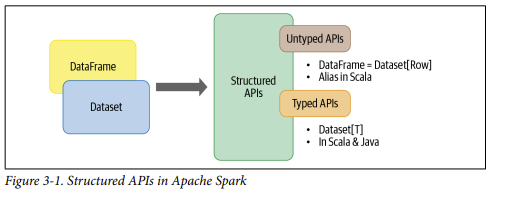
Conceptually, you can think of a DataFrame in Scala as an alias for a collection of
generic objects, Dataset[Row], where a Row is a generic untyped JVM object that may
hold different types of fields. A Dataset, by contrast, is a collection of strongly typed
JVM objects in Scala or a class in Java. Or, as the Dataset documentation puts it, a
Dataset is:

a strongly typed collection of domain-specific objects that can be transformed in parallel using functional or relational operations. Each Dataset [in Scala] also has an untyped view called a DataFrame, which is a Dataset of Row.

#### Typed Objects, Untyped Objects, and Generic Rows
In Spark’s supported languages, Datasets make sense only in Java and Scala, whereas
in Python and R only DataFrames make sense. This is because Python and R are not
compile-time type-safe; types are dynamically inferred or assigned during execution,
not during compile time. The reverse is true in Scala and Java: types are bound to variables and objects at compile time. In Scala, however, a DataFrame is just an alias
for untyped Dataset[Row]. Table 3-6 distills it in a nutshell.

Row is a generic object type in Spark, holding a collection of mixed types that can be
accessed using an index. Internally, Spark manipulates Row objects, converting them
to the equivalent types covered in Table 3-2 and Table 3-3. For example, an Int as one
of your fields in a Row will be mapped or converted to IntegerType or IntegerType()
respectively for Scala or Java and Python:
~~~
// In Scala
import org.apache.spark.sql.Row
val row = Row(350, true, "Learning Spark 2E", null)
# In Python
from pyspark.sql import Row
row = Row(350, True, "Learning Spark 2E", None)
Using an index into the Row object, you can access individual fields with its public
getter methods:
// In Scala
row.getInt(0)
res23: Int = 350
row.getBoolean(1)
res24: Boolean = true
row.getString(2)
res25: String = Learning Spark 2E
# In Python
row[0]
Out[13]: 350
row[1]
Out[14]: True
row[2]
Out[15]: 'Learning Spark 2E'
~~~
By contrast, typed objects are actual Java or Scala class objects in the JVM. Each element in a Dataset maps to a JVM object.

#### Creating Datasets
As with creating DataFrames from data sources, when creating a Dataset you have to
know the schema. In other words, you need to know the data types. Although with
JSON and CSV data it’s possible to infer the schema, for large data sets this is
resource-intensive (expensive). When creating a Dataset in Scala, the easiest way to
specify the schema for the resulting Dataset is to use a case class. In Java, JavaBean
classes are used (we further discuss JavaBean and Scala case class in Chapter 6).

___Scala: Case classes___

When you wish to instantiate your own domain-specific object as a Dataset, you can
do so by defining a case class in Scala. As an example, let’s look at a collection of readings from Internet of Things (IoT) devices in a JSON file (we use this file in the endto-end example later in this section).

Our file has rows of JSON strings that look as follows:
~~~
{"device_id": 198164, "device_name": "sensor-pad-198164owomcJZ", "ip":
"80.55.20.25", "cca2": "PL", "cca3": "POL", "cn": "Poland", "latitude":
53.080000, "longitude": 18.620000, "scale": "Celsius", "temp": 21,
"humidity": 65, "battery_level": 8, "c02_level": 1408,"lcd": "red",
"timestamp" :1458081226051}
~~~
To express each JSON entry as DeviceIoTData, a domain-specific object, we can
define a Scala case class:
~~~
case class DeviceIoTData (battery_level: Long, c02_level: Long,
cca2: String, cca3: String, cn: String, device_id: Long,
device_name: String, humidity: Long, ip: String, latitude: Double,
lcd: String, longitude: Double, scale:String, temp: Long,
timestamp: Long)
~~~
Once defined, we can use it to read our file and convert the returned Dataset[Row]
into Dataset[DeviceIoTData] (output truncated to fit on the page):
~~~
// In Scala
val ds = spark.read
.json("/databricks-datasets/learning-spark-v2/iot-devices/iot_devices.json")
.as[DeviceIoTData]
ds: org.apache.spark.sql.Dataset[DeviceIoTData] = [battery_level...]
ds.show(5, false)
+-------------|---------|----|----|-------------|---------|---+
|battery_level|c02_level|cca2|cca3|cn |device_id|...|
+-------------|---------|----|----|-------------|---------|---+
|8 |868 |US |USA |United States|1 |...|
|7 |1473 |NO |NOR |Norway |2 |...|
|2 |1556 |IT |ITA |Italy |3 |...|
|6 |1080 |US |USA |United States|4 |...|
|4 |931 |PH |PHL |Philippines |5 |...|
+-------------|---------|----|----|-------------|---------|---+
only showing top 5 rows
~~~

#### Dataset Operations
Just as you can perform transformations and actions on DataFrames, so you can with
Datasets. Depending on the kind of operation, the results will vary:
~~~
// In Scala
val filterTempDS = ds.filter({d => {d.temp > 30 && d.humidity > 70})
filterTempDS: org.apache.spark.sql.Dataset[DeviceIoTData] = [battery_level...]
filterTempDS.show(5, false)
+-------------|---------|----|----|-------------|---------|---+
|battery_level|c02_level|cca2|cca3|cn |device_id|...|
+-------------|---------|----|----|-------------|---------|---+
|0 |1466 |US |USA |United States|17 |...|
|9 |986 |FR |FRA |France |48 |...|
|8 |1436 |US |USA |United States|54 |...|
|4 |1090 |US |USA |United States|63 |...|
|4 |1072 |PH |PHL |Philippines |81 |...|
+-------------|---------|----|----|-------------|---------|---+
only showing top 5 rows
~~~
In this query, we used a function as an argument to the Dataset method filter().
This is an overloaded method with many signatures. The version we used, fil
ter(func: (T) > Boolean): Dataset[T], takes a lambda function, func: (T) >
Boolean, as its argument.

The argument to the lambda function is a JVM object of type DeviceIoTData. As
such, we can access its individual data fields using the dot (.) notation, like you
would in a Scala class or JavaBean.

Another thing to note is that with DataFrames, you express your filter() conditions as SQL-like DSL operations, which are language-agnostic (as we saw earlier in
the fire calls examples). With Datasets, we use language-native expressions as Scala or
Java code.

Here’s another example that results in another, smaller Dataset:
~~~
// In Scala
case class DeviceTempByCountry(temp: Long, device_name: String, device_id: Long,
 cca3: String)
val dsTemp = ds
 .filter(d => {d.temp > 25})
 .map(d => (d.temp, d.device_name, d.device_id, d.cca3))
 .toDF("temp", "device_name", "device_id", "cca3")
 .as[DeviceTempByCountry]
dsTemp.show(5, false)
+----+---------------------+---------+----+
|temp|device_name |device_id|cca3|
+----+---------------------+---------+----+
|34 |meter-gauge-1xbYRYcj |1 |USA |
|28 |sensor-pad-4mzWkz |4 |USA |
|27 |sensor-pad-6al7RTAobR|6 |USA |
|27 |sensor-pad-8xUD6pzsQI|8 |JPN |
|26 |sensor-pad-10BsywSYUF|10 |USA |
+----+---------------------+---------+----+
only showing top 5 rows
~~~
Or you can inspect only the first row of your Dataset:
~~~
val device = dsTemp.first()
println(device)
device: DeviceTempByCountry =
DeviceTempByCountry(34,meter-gauge-1xbYRYcj,1,USA)
~~~
Alternatively, you could express the same query using column names and then cast to
a Dataset[DeviceTempByCountry]:
~~~
// In Scala
val dsTemp2 = ds
 .select($"temp", $"device_name", $"device_id", $"device_id", $"cca3")
 .where("temp > 25")
 .as[DeviceTempByCountry]
 ~~~
Semantically, select() is like map() in the previous query, in that
both of these queries select fields and generate equivalent results.

To recap, the operations we can perform on Datasets—filter(), map(), groupBy(),
select(), take(), etc.—are similar to the ones on DataFrames. In a way, Datasets are
similar to RDDs in that they provide a similar interface to its aforementioned meth‐
ods and compile-time safety but with a much easier to read and an object-oriented
programming interface.

When we use Datasets, the underlying Spark SQL engine handles the creation, con‐
version, serialization, and deserialization of the JVM objects. It also takes care of offJava heap memory management with the help of Dataset encoders. (We will talk more
about Datasets and memory management in Chapter 6.)

#### End-to-End Dataset Example
In this end-to-end Dataset example you’ll conduct similar exploratory data analysis,
ETL (extract, transform, and load), and data operations as in the DataFrame example,
using the IoT data set. This data set is small and fake, but our main goal here is to
illustrate the clarity with which you can express queries with Datasets and the readability of those queries, just as we did with DataFrames.

Again, for brevity, we won’t include all the example code here; however, we have furnished the notebook in the GitHub repo. The notebook explores common operations
you might conduct with this data set. Using the Dataset API, we attempt to do the
following:

1. Detect failing devices with battery levels below a threshold.
2. Identify offending countries with high levels of CO2 emissions.
3. Compute the min and max values for temperature, battery level, CO2, and
humidity.
4. Sort and group by average temperature, CO2, humidity, and country.

## DataFrames Versus Datasets
By now you may be wondering why and when you should use DataFrames or Datasets. In many cases either will do, depending on the languages you are working in, but
there are some situations where one is preferable to the other. Here are a few
examples:
* If you want to tell Spark what to do, not how to do it, use DataFrames or Datasets.
* If you want rich semantics, high-level abstractions, and DSL operators, use DataFrames or Datasets.
* If you want strict compile-time type safety and don’t mind creating multiple case
classes for a specific Dataset[T], use Datasets.
* If your processing demands high-level expressions, filters, maps, aggregations,
computing averages or sums, SQL queries, columnar access, or use of relational
operators on semi-structured data, use DataFrames or Datasets.
* If your processing dictates relational transformations similar to SQL-like queries,
use DataFrames.
* If you want to take advantage of and benefit from Tungsten’s efficient serialization with Encoders, , use Datasets.
* If you want unification, code optimization, and simplification of APIs across
Spark components, use DataFrames.
* If you are an R user, use DataFrames.
* If you are a Python user, use DataFrames and drop down to RDDs if you need
more control.
* If you want space and speed efficiency, use DataFrames.
* If you want errors caught during compilation rather than at runtime, choose the
appropriate API as depicted in Figure 3-2.
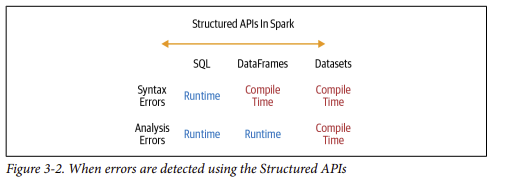


## When to Use RDDs
You may ask: Are RDDs being relegated to second-class citizens? Are they being deprecated? The answer is a resounding no! The RDD API will continue to be supported,
although all future development work in Spark 2.x and Spark 3.0 will continue to
have a DataFrame interface and semantics rather than using RDDs.

There are some scenarios where you’ll want to consider using RDDs, such as when
you:
* Are using a third-party package that’s written using RDDs
* Can forgo the code optimization, efficient space utilization, and performance
benefits available with DataFrames and Datasets
* Want to precisely instruct Spark how to do a query

What’s more, you can seamlessly move between DataFrames or Datasets and RDDs at
will using a simple API method call, df.rdd. (Note, however, that this does have a
cost and should be avoided unless necessary.) After all, DataFrames and Datasets are
built on top of RDDs, and they get decomposed to compact RDD code during wholestage code generation, which we discuss in the next section.

Finally, the preceding sections provided some intuition on how Structured APIs in
Spark enable developers to use easy and friendly APIs to compose expressive queries
on structured data. In other words, you tell Spark what to do, not how to do it, using high-level operations, and it ascertains the most efficient way to build a query and
generates compact code for you.

This process of building efficient queries and generating compact code is the job of
the Spark SQL engine. It’s the substrate upon which the Structured APIs we’ve been
looking at are built. Let’s peek under the hood at that engine now.

## Spark SQL and the Underlying Engine
At a programmatic level, Spark SQL allows developers to issue ANSI SQL:2003–compatible queries on structured data with a schema. Since its introduction in Spark 1.3,
Spark SQL has evolved into a substantial engine upon which many high-level structured functionalities have been built. Apart from allowing you to issue SQL-like queries on your data, the Spark SQL engine:
* Unifies Spark components and permits abstraction to DataFrames/Datasets in
Java, Scala, Python, and R, which simplifies working with structured data sets.
* Connects to the Apache Hive metastore and tables.
* Reads and writes structured data with a specific schema from structured file for‐
mats (JSON, CSV, Text, Avro, Parquet, ORC, etc.) and converts data into tempo‐
rary tables.
* Offers an interactive Spark SQL shell for quick data exploration.
* Provides a bridge to (and from) external tools via standard database JDBC/
ODBC connectors.
* Generates optimized query plans and compact code for the JVM, for final
execution.

Figure 3-3 shows the components that Spark SQL interacts with to achieve all of this.

At the core of the Spark SQL engine are the Catalyst optimizer and Project Tungsten.
Together, these support the high-level DataFrame and Dataset APIs and SQL queries.
We’ll talk more about Tungsten in Chapter 6; for now, let’s take a closer look at the
optimizer.

## The Catalyst Optimizer
The Catalyst optimizer takes a computational query and converts it into an execution
plan. It goes through four transformational phases, as shown in Figure 3-4:
1. Analysis
2. Logical optimization
3. Physical planning
4. Code generation
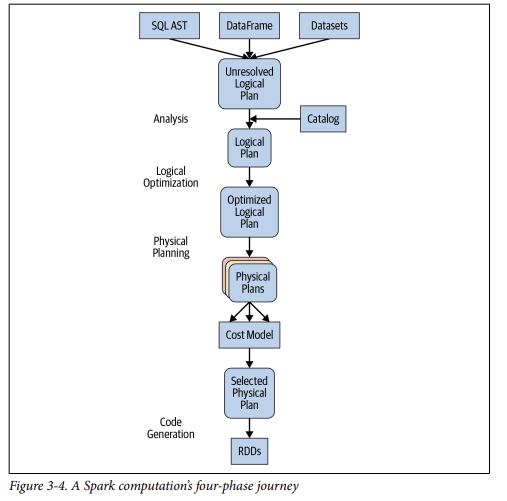
For example, consider one of the queries from our M&Ms example in Chapter 2.
Both of the following sample code blocks will go through the same process, eventually ending up with a similar query plan and identical bytecode for execution. That is,
regardless of the language you use, your computation undergoes the same journey
and the resulting bytecode is likely the same:
~~~
# In Python
count_mnm_df = (mnm_df
 .select("State", "Color", "Count")
 .groupBy("State", "Color")
 .agg(count("Count")
 .alias("Total"))
 .orderBy("Total", ascending=False))
 -- In SQL
SELECT State, Color, Count, sum(Count) AS Total
FROM MNM_TABLE_NAME
GROUP BY State, Color, Count
ORDER BY Total DESC
~~~

We have talked at a conceptual level about the workings of the
Spark SQL engine, with its two principal components: the Catalyst
optimizer and Project Tungsten. The internal technical workings
are beyond the scope of this book; however, for the curious, we
encourage you to check out the references in the text for in-depth
technical discussions.

~~~
count_mnm_df.explain(True)
== Parsed Logical Plan ==
'Sort ['Total DESC NULLS LAST], true
+- Aggregate [State#10, Color#11], [State#10, Color#11, count(Count#12) AS...]
 +- Project [State#10, Color#11, Count#12]
 +- Relation[State#10,Color#11,Count#12] csv
== Analyzed Logical Plan ==
State: string, Color: string, Total: bigint
Sort [Total#24L DESC NULLS LAST], true
+- Aggregate [State#10, Color#11], [State#10, Color#11, count(Count#12) AS...]
 +- Project [State#10, Color#11, Count#12]
 +- Relation[State#10,Color#11,Count#12] csv
== Optimized Logical Plan ==
Sort [Total#24L DESC NULLS LAST], true
+- Aggregate [State#10, Color#11], [State#10, Color#11, count(Count#12) AS...]
 +- Relation[State#10,Color#11,Count#12] csv
== Physical Plan ==
*(3) Sort [Total#24L DESC NULLS LAST], true, 0
+- Exchange rangepartitioning(Total#24L DESC NULLS LAST, 200)
 +- *(2) HashAggregate(keys=[State#10, Color#11], functions=[count(Count#12)],
output=[State#10, Color#11, Total#24L])
 +- Exchange hashpartitioning(State#10, Color#11, 200)
 +- *(1) HashAggregate(keys=[State#10, Color#11],
functions=[partial_count(Count#12)], output=[State#10, Color#11, count#29L])
 +- *(1) FileScan csv [State#10,Color#11,Count#12] Batched: false,
Format: CSV, Location:
InMemoryFileIndex[file:/Users/jules/gits/LearningSpark2.0/chapter2/py/src/...
dataset.csv], PartitionFilters: [], PushedFilters: [], ReadSchema:
struct<State:string,Color:string,Count:int>
~~~
Let’s consider another DataFrame computation example. The following Scala code
undergoes a similar journey as the underlying engine optimizes its logical and physi‐
cal plans:
~~~
// In Scala
// Users DataFrame read from a Parquet table
val usersDF = ...
// Events DataFrame read from a Parquet table
val eventsDF = ...
// Join two DataFrames
val joinedDF = users
 .join(events, users("id") === events("uid"))
 .filter(events("date") > "2015-01-01")
 ~~~
After going through an initial analysis phase, the query plan is transformed and rear‐
ranged by the Catalyst optimizer as shown in Figure 3-5.

Let’s go through each of the four query optimization phases..

___Phase 1: Analysis___

The Spark SQL engine begins by generating an abstract syntax tree (AST) for the SQL
or DataFrame query. In this initial phase, any columns or table names will be resolved
by consulting an internal Catalog, a programmatic interface to Spark SQL that holds
a list of names of columns, data types, functions, tables, databases, etc. Once they’ve
all been successfully resolved, the query proceeds to the next phase.

___Phase 2: Logical optimization___

As Figure 3-4 shows, this phase comprises two internal stages. Applying a standardrule based optimization approach, the Catalyst optimizer will first construct a set of
multiple plans and then, using its cost-based optimizer (CBO), assign costs to each
plan. These plans are laid out as operator trees (like in Figure 3-5); they may include,
for example, the process of constant folding, predicate pushdown, projection pruning, Boolean expression simplification, etc. This logical plan is the input into the
physical plan.

___Phase 3: Physical planning___

In this phase, Spark SQL generates an optimal physical plan for the selected logical
plan, using physical operators that match those available in the Spark execution
engine.

___Phase 4: Code generation___

The final phase of query optimization involves generating efficient Java bytecode to
run on each machine. Because Spark SQL can operate on data sets loaded in memory,
Spark can use state-of-the-art compiler technology for code generation to speed up
execution. In other words, it acts as a compiler. Project Tungsten, which facilitates
whole-stage code generation, plays a role here.

Just what is whole-stage code generation? It’s a physical query optimization phase that
collapses the whole query into a single function, getting rid of virtual function calls
and employing CPU registers for intermediate data. The second-generation Tungsten
engine, introduced in Spark 2.0, uses this approach to generate compact RDD code
for final execution. This streamlined strategy significantly improves CPU efficiency
and performance.

We have talked at a conceptual level about the workings of the
Spark SQL engine, with its two principal components: the Catalyst
optimizer and Project Tungsten. The internal technical workings
are beyond the scope of this book; however, for the curious, we
encourage you to check out the references in the text for in-depth
technical discussions.

## Summary
In this chapter, we took a deep dive into Spark’s Structured APIs, beginning with a
look at the history and merits of structure in Spark.

Through illustrative common data operations and code examples, we demonstrated
that the high-level DataFrame and Dataset APIs are far more expressive and intuitive
than the low-level RDD API. Designed to make processing of large data sets easier,
the Structured APIs provide domain-specific operators for common data operations,
increasing the clarity and expressiveness of your code.

We explored when to use RDDs, DataFrames, and Datasets, depending on your use
case scenarios.

And finally, we took a look under the hood to see how the Spark SQL engine’s main
components—the Catalyst optimizer and Project Tungsten—support structured highlevel APIs and DSL operators. As you saw, no matter which of the Spark-supported
languages you use, a Spark query undergoes the same optimization journey, from logical and physical plan construction to final compact code generation.

The concepts and code examples in this chapter have laid the groundwork for the
next two chapters, in which we will further illustrate the seamless interoperability
between DataFrames, Datasets, and Spark SQL.